# Construction table work

The following notebook applies to the spreadsheets taken from here
http://www.ons.gov.uk/businessindustryandtrade/constructionindustry/datasets/outputintheconstructionindustry

(We do not have a good way of managing the input and output, so download it to the local directory so that the next cell which loads up the spreadsheet can run from there.)

The following works through processing 8 of the tables which are in a similar format and are generally presentations of the same data -- Table1 sets all values at 2013 to 100, Table 3 is percentage change, Tables 2 and 4 are volume and value (volume is .  Each pair of tables (a and b) is in seasonal and non-seasonal adjusted (more later).

There are 14 columns in each table, 5 of which are calculated by summing the other columns to within plus or minus one, which means that the source data has been rounded after summing before it is copied into here.

The variation/confidence interval on the most recent numbers is given on Table 11, but this is not included for the previous months.  This could be given for all the numbers at the same in a similar format table, which would make it useful for statistical time series modelling.

The methodology for seasonal adjustment (a time-series process) is given [here](https://www.ons.gov.uk/businessindustryandtrade/constructionindustry/qmis/constructionoutputqmi) as being from X-13 Arima, a US Census program that is written in Fortran and takes the numbers in a particular flat data form.  This means that anywhere with seasonal adjustment is already implementing databaker (flattening the numbers into a time series) probably by hand for the purpose of feeding it into this program.  

We could automate calling the seasonal adjustment software directly from databaker so as to remove these series and simplify the incoming data.  The science of seasonal adjustment is under-developed if it doesn't account for the variance of each measuring point, like the kalman filter.  The papers I have seen are over-complex for a one-dimensional problem, and the software is inflexible -- you can't revise and adjust the equations because the code is too large when it should be using single function calls to scipy signal processing.  







In [6]:
# Load up our construction output table from the url page:
# durl = "http://www.ons.gov.uk/businessindustryandtrade/constructionindustry/datasets/outputintheconstructionindustry"

%matplotlib inline 
from matplotlib import pyplot as plt
from databaker.framework import *
import pandas as pd, numpy as np, re

previewhtml = "preview.html"
fname = "constructionoutputdecember2016.xls"
tabs = loadxlstabs(fname)


Loading constructionoutputdecember2016.xls which has size 984576 bytes
Table names: ['Cover Sheet', 'Contents', 'Table 1a', 'Table 1b', 'Table 2a', 'Table 2b', 'Table 3a', 'Table 3b', 'Table 4', 'Table 4a', 'Table 5', 'Table 6', 'Table 7a', 'Table 7b', 'Table 9a', 'Table 10', 'Table 11', 'Table 12', 'Table 13', 'Table 14']


In [7]:
# Get the tables which match the most common format and the titles
import re
htabs = [ ]
for tab in tabs:
    if tab.excel_ref("C6").value == "New Housing":
        htabs.append(tab)
        print(tab.name, "\t", re.sub("\s+", " ", tab.excel_ref("C2").value))

savepreviewhtml(htabs[0], previewhtml)

Table 1a 	 CONSTRUCTION OUTPUT IN GREAT BRITAIN: VOLUME SEASONALLY ADJUSTED INDEX NUMBERS - BY SECTOR
Table 1b 	 CONSTRUCTION OUTPUT IN GREAT BRITAIN: VOLUME NON-SEASONALLY ADJUSTED INDEX NUMBERS - BY SECTOR
Table 2a 	 CONSTRUCTION OUTPUT: VOLUME SEASONALLY ADJUSTED BY SECTOR
Table 2b 	 CONSTRUCTION OUTPUT: VOLUME NON-SEASONALLY ADJUSTED, BY SECTOR
Table 3a 	 CONSTRUCTION OUTPUT: VOLUME SEASONALLY ADJUSTED PERCENTAGE CHANGE PERIOD ON PERIOD
Table 3b 	 CONSTRUCTION OUTPUT: VOLUME SEASONALLY ADJUSTED PERCENTAGE CHANGE ON SAME PERIOD A YEAR EARLIER - BY SECTOR
Table 4 	 CONSTRUCTION OUTPUT: VALUE NON-SEASONALLY ADJUSTED, CURRENT PRICES BY SECTOR
Table 4a 	 CONSTRUCTION OUTPUT: VALUE SEASONALLY ADJUSTED - CURRENT PRICES BY SECTOR
Table 9a 	 IMPLIED OUTPUT PRICE INDICATOR, NON-SEASONALLY ADJUSTED
tablepart 'Table 1a' written #injblock1005


/home/julian/repositories/royalstatsoctalk/preview.html

In [8]:

# spread those multi-cell heading values across widthwise and move vertical ones down
# (should be a function within the library)

def FixMultipleCellsHeading(tab):
    hh = tab.excel_ref("C6:P9").is_not_whitespace()
    for cc in hh:
        val = cc.value
        ch = set(cc.children().unordered_cells)
        xwidth = len(set(c.x  for c in ch))
        ywidth = len(set(c.y  for c in ch))
        if ywidth == 1:
            for c in ch:
                c.value = val
        elif xwidth == 1:
            bottomcell = max(ch, key=lambda X:X.y)
            for c in ch:
                c.value = ''
            bottomcell.value = val
            

FixMultipleCellsHeading(htabs[3])
savepreviewhtml(htabs[3], previewhtml)


tablepart 'Table 2b' written #injblock1006


/home/julian/repositories/royalstatsoctalk/preview.html

In [9]:
# Build up the conversion segment
tab = htabs[0]
period = tab.filter("Period")
savepreviewhtml(period, previewhtml)
# etc

tablepart 'Table 1a' written #injblock1007


/home/julian/repositories/royalstatsoctalk/preview.html

In [10]:
# select the complete conversion segments
def CSegNormal(tab):
    period = tab.filter("Period")
    s4headings = period.shift((0,3)).fill(RIGHT).is_not_whitespace()
    s4up = s4headings.shift((0,-1))
    s4up2 = s4headings.shift((0,-3))
    s4up3 = s4headings.shift((0,-4))
    obs = s4headings.fill(DOWN).is_not_whitespace()
    subyear = s4headings.by_index(1).shift(LEFT).fill(DOWN)
    year = subyear.shift(LEFT).is_not_whitespace()

    hdimheadings = HDim(s4headings, "s4heading", DIRECTLY, UP)
    hdimdesc1 = HDim(s4up, "desc1", DIRECTLY, UP)
    hdimdesc2 = HDim(s4up2, "desc2", DIRECTLY, UP)
    hdimdesc3 = HDim(s4up3, "desc3", DIRECTLY, UP, LEFT)
    hdimyear = HDim(year, "year", CLOSEST, UP)
    hdimsubyear = HDim(subyear, "subyear", DIRECTLY, LEFT)

    cs = ConversionSegment(obs, [hdimheadings, hdimdesc1, hdimdesc2, hdimdesc3, hdimsubyear, hdimyear])
    return cs

cs = CSegNormal(htabs[0])
savepreviewhtml(cs, previewhtml)



tablepart 'Table 1a' written #injblock1008
javascript calculated


/home/julian/repositories/royalstatsoctalk/preview.html

In [11]:
# Convert a conversion segment to pandas
tab = htabs[3]
FixMultipleCellsHeading(tab)
cs = CSegNormal(tab)
k = cs.topandas()
#k.subyear + " " + k.year
k.tail()

,OBS,s4heading,desc1,desc2,desc3,subyear,year
2571,1416.0,MV4J,Private,Housing,Repair and Maintenance,Dec,2016.0
2572,1911.0,MV4K,Total,Housing,Repair and Maintenance,Dec,2016.0
2573,1731.0,MV4L,Non Housing R&M,,Repair and Maintenance,Dec,2016.0
2574,3642.0,MV4M,All Repair and Maintenance,,,Dec,2016.0
2575,10681.0,MV4N,All Work,,,Dec,2016.0


In [12]:
# Full pandas conversion function with date fixing and heading concatenation
def ConvertPD(cs):
    k = cs.topandas()
    k["TIME"] = k.subyear + " " + k.year
    pdguessforceTIMEUNIT(k)
    k = k.drop(["subyear", "year"], axis=1)
    k.TIME = pd.to_datetime(k.apply(lambda row: row.TIME  if "Q" not in row.TIME else row.TIME.replace(" ", ""), axis=1))
    def rj(r):
        rs = [ ]
        if r.desc1:  rs.append(r.desc1.replace("-", "").strip())  # inconsistent Infra-struc-ture
        if r.desc2:  rs.append(r.desc2.strip())
        if r.desc3:  rs.append(r.desc3.strip())
        return ",".join(rs)
    k["desc"] = k.apply(lambda r: rj(r), axis=1)
    k = k.drop(["desc1", "desc2", "desc3", "s4heading"], axis=1)
    k = k.sort_values(by=["desc", "TIMEUNIT", "TIME"])
    k = k.set_index(["desc", "TIMEUNIT", "TIME"])
    return k 




In [13]:
# Run the full conversion across each of our tabs we've found
pds = [ ]
for tab in htabs:
    FixMultipleCellsHeading(tab)
    cs = CSegNormal(tab)
    k = ConvertPD(cs)
    pds.append(k)
    

In [14]:
# Now put these into meaningful variables (note the chaos)

consindexSA, consindexNSA = pds[0], pds[1]
consvolumeSA, consvolumeNSA = pds[2], pds[3]
conspercchangePeriodSA, conspercchangeYearSA = pds[4], pds[5]
consvalueNSA, consvalueSA = pds[6], pds[7]
conspriceindicNSA = pds[8]
    
#savepreviewhtml(consindexSA, previewhtml)


In [15]:
d = "All New Work"
k = consvolumeNSA

# look at the different levels
k.index.levels[1]

# we can get out a single element as a triple-wise index (but handling the Timestamp is a nuisance)
# (See timestamp documentation)
s = k.iloc[0]
s.name
#k.loc[(d, 'Year', pd.Timestamp('2010-01-01 00:00:00'))]

k.xs(key=d, level=0)
#d
k.index.levels[0]


Index(['All New Work', 'All Repair and Maintenance', 'All Work',
       'Infrastructure,Other New Work',
       'Non Housing R&M,Repair and Maintenance',
       'Private Commercial,Excluding Infrastructure,Other New Work',
       'Private Industrial,Excluding Infrastructure,Other New Work',
       'Private,Housing,Repair and Maintenance', 'Private,New Housing',
       'Public,Excluding Infrastructure,Other New Work',
       'Public,Housing,Repair and Maintenance', 'Public,New Housing',
       'Total Housing', 'Total,Housing,Repair and Maintenance'],
      dtype='object', name='desc')

In [16]:
k = consvolumeNSA

k.xs(key='Public,New Housing', level=0)  # <-- DataFrame
k.xs(key='Public,New Housing', level=0).OBS  # <-- Series

# show the dataframe
pd.DataFrame(data={"col1":k.xs(key='Public,New Housing', level=0).OBS, 
                   "col2":k.xs(key='Private,New Housing', level=0).OBS, 
                   "col3":k.xs(key='Total Housing', level=0).OBS}) 

# can add DataFrames (lined up by their indexes)
k.xs(key='Public,New Housing', level=0)+k.xs(key='Private,New Housing', level=0)-k.xs(key='Total Housing', level=0)

# Prove that the columns add up
k = consvalueNSA
THerr = (k.xs(key='Public,New Housing', level=0)+k.xs(key='Private,New Housing', level=0)-k.xs(key='Total Housing', level=0))
max(np.abs(THerr.OBS))


2.0

In [17]:
k = consvolumeNSA
k = consvalueNSA

TNWerr = k.xs('Infrastructure,Other New Work')+k.xs('Private Commercial,Excluding Infrastructure,Other New Work')\
         +k.xs('Private Industrial,Excluding Infrastructure,Other New Work')+k.xs('Public,Excluding Infrastructure,Other New Work')\
         -k.xs('All New Work')+k.xs('Total Housing')
TNWerr
max(np.abs(TNWerr.OBS))

k = consvolumeNSA
TRMerr = k.xs('Public,Housing,Repair and Maintenance')+k.xs('Private,Housing,Repair and Maintenance')\
         -k.xs('Total,Housing,Repair and Maintenance')
TRMerr
max(np.abs(TRMerr.OBS))

# Note bug of missing ,Housing, heading extension in Table 4
k = consvalueNSA
TRMerr = k.xs('Public,Housing,Repair and Maintenance')+k.xs('Private,Housing,Repair and Maintenance')\
         -k.xs('Total,Repair and Maintenance')
TRMerr
max(np.abs(TRMerr.OBS))



2.0

In [18]:
k = consvolumeNSA

TRMerr = k.xs('Non Housing R&M,Repair and Maintenance')+k.xs('Total,Housing,Repair and Maintenance')\
         -k.xs('All Repair and Maintenance')
max(np.abs(TRMerr.OBS))

k = consvalueNSA

TRMerr = k.xs('Total,Repair and Maintenance')+k.xs('Infrastructure,Repair and Maintenance')\
         +k.xs('Public,Other Work,Repair and Maintenance')+k.xs('Private,Other Work,Repair and Maintenance')\
         -k.xs('All Repair and Maintenance')
max(np.abs(TRMerr.OBS))

k = consvolumeNSA
#k = consvalueNSA
TRMerr = k.xs('All New Work')+k.xs('All Repair and Maintenance')\
         -k.xs('All Work')
max(np.abs(TRMerr.OBS))
#'', 'All Repair and Maintenance', 'All Work',
#'Non Housing R&M,Repair and Maintenance',
#k.index.levels[0]


1.0

## Redundant Column Results:

* For consvolumeNSA, consvalueNSA
  * Total Housing = Private,New Housing + Public,New Housing
  * All New Work = Total Housing + Infrastruc-ture,Other New Work + Private Commercial,Excluding Infrastructure,Other New Work + Private Industrial,Excluding Infrastructure,Other New Work + Public,Excluding Infrastructure,Other New Work
  * Total(,Housing),Repair and Maintenance = Public,Housing,Repair and Maintenance + Private,Housing,Repair and Maintenance'
  * All Work = All New Work + All Repair and Maintenance

* consvolumeNSA
  * All Repair and Maintenance = Non Housing R&M,Repair and Maintenance + Total,Housing,Repair and Maintenance
* consvalueNSA
  * All Repair and Maintenance = Total,Repair and Maintenance + Infrastructure,Repair and Maintenance + Public,Other Work,Repair and Maintenance + Private,Other Work,Repair and Maintenance
  


In [19]:
k = consvolumeNSA
d = 'Public,New Housing'
s = k.xs((d, "Month")).resample("QS").apply(np.sum) - k.xs((d, "Quarter"))
s = k.xs((d, "Quarter")).resample("AS").apply(np.sum) - k.xs((d, "Year"))
max(np.abs(s.dropna().OBS))



1.0

In [20]:
# check resamples
k = consvolumeNSA.OBS.unstack(level=0)
s = k.xs("Month").resample("QS").apply(np.sum) - k.xs("Quarter")
s = k.xs("Quarter").resample("AS").apply(np.sum) - k.xs("Year")
s = s.dropna()
max(max(s.iloc[i])  for i in range(len(s)))

# Note that there is a disagreement here with the year summary
k = consvalueNSA.OBS.unstack(level=0)
#s = k.xs("Month").resample("QS").apply(np.sum) - k.xs("Quarter")
#s = k.xs("Quarter").resample("AS").apply(np.sum) - k.xs("Year")
s = s.dropna()

#k.xs("Quarter").to_csv("UKconstructionvaluequarter.csv")

In [21]:
# Prove the index values by dividing one by other
k = consvolumeNSA.OBS.unstack(level=0).xs("Month")
kI = consindexNSA.OBS.unstack(level=0).xs("Month")
(k/kI).head()




desc,All New Work,All Repair and Maintenance,All Work,"Infrastructure,Other New Work","Non Housing R&M,Repair and Maintenance","Private Commercial,Excluding Infrastructure,Other New Work","Private Industrial,Excluding Infrastructure,Other New Work","Private,Housing,Repair and Maintenance","Private,New Housing","Public,Excluding Infrastructure,Other New Work","Public,Housing,Repair and Maintenance","Public,New Housing",Total Housing,"Total,Housing,Repair and Maintenance"
TIME,,,,,,,,,,,,,,
2010-01-01,60.727497,37.992228,98.718593,12.272189,19.002770,18.845701,2.871397,12.884615,14.929825,8.190731,6.101861,3.586207,18.500000,18.990268
2010-02-01,60.695469,37.997750,98.682505,12.277020,19.016787,18.839104,2.875494,12.883939,14.921090,8.194662,6.105727,3.588235,18.500000,18.983051
2010-03-01,60.686016,38.007700,98.717015,12.279226,19.023162,18.847550,2.870608,12.871587,14.922711,8.190985,6.105508,3.583181,18.505618,18.986175
2010-04-01,60.662188,38.004338,98.644578,12.273161,19.022727,18.856859,2.867420,12.881720,14.922711,8.192128,6.100386,3.587060,18.503401,18.983402
2010-05-01,60.687732,37.989418,98.731707,12.264325,19.025522,18.849810,2.874647,12.887113,14.908046,8.194631,6.099815,3.586957,18.502732,18.987342


In [22]:
# what is seasonal adjustment?  How is it different in year?
k = consvalueNSA.OBS.unstack(level=0).xs("Year")
kSA = consvalueSA.OBS.unstack(level=0).xs("Year")
d = "Public,New Housing"
s = (kSA-k).dropna()
max(max(s.iloc[i])  for i in range(len(s)))

#k = consvalueNSA.OBS.unstack(level=0).xs("Quarter")
#kSA = consvalueNSA.OBS.unstack(level=0).xs("Quarter")
#kSA[d].plot()
#k[d].plot()
#(k-kSA)[d].plot()


843.0

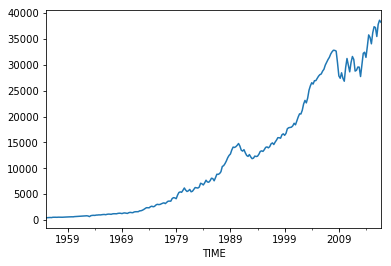

In [23]:
# goes back to 1955, though you can't find it in the spreadsheet
d = "All Work"
kV = consvalueNSA.OBS.unstack(level=0).xs("Quarter")
kV[d].plot()

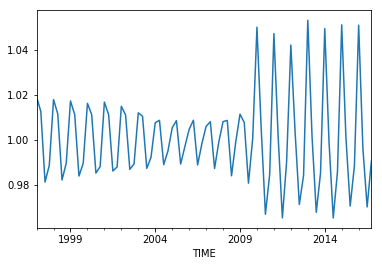

In [25]:
# what is different ratios for the years and months
k = consvolumeNSA.OBS.unstack(level=0).xs("Year")
kSA = consvolumeSA.OBS.unstack(level=0).xs("Year")
kV = consvalueNSA.OBS.unstack(level=0).xs("Year")
kVSA = consvalueSA.OBS.unstack(level=0).xs("Year")

#(k/kV)["All New Work"].dropna()
d = "All Work"
#kV[d].plot()
dn = "All New Work"
#kV[dn].plot()
#(kV[dn]/kV[d]).plot()
#k[d].plot()
#kSA[d].plot()
#kVSA[d].plot()
kV.head()

#(kV["Public,New Housing"]/kV["Total Housing"]).plot()
kV = consvalueNSA.OBS.unstack(level=0).xs("Quarter")
kVSA = consvalueSA.OBS.unstack(level=0).xs("Quarter")
#kV["Public,New Housing"].plot()
#kV["Total Housing"].plot()

#(kV["Public,New Housing"]).plot()
#(kV["Total Housing"]).plot()

#kV = consvalueNSA.OBS.unstack(level=0).xs("Month")
#kVSA = consvalueSA.OBS.unstack(level=0).xs("Month")
(kVSA[d]/kV[d]).dropna().plot()

if False:
    d = "Private,New Housing"
    #kVSA[d].plot()
    #kV[d].plot()
    
    s = kV[d] - kVSA[d]
    s.dropna().plot()
    (kV[d]*0.1).plot()



,bovis
TIME,
2002-01-01,NaN
2003-01-01,461.0
2004-01-01,478.0
2005-01-01,559.0
2006-01-01,521.0
2007-01-01,597.0
2008-01-01,555.0
2009-01-01,282.0
2010-01-01,281.0


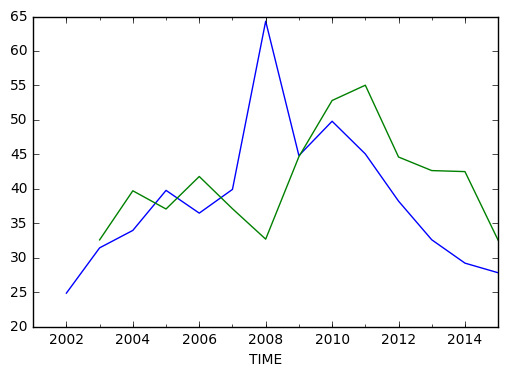

In [441]:
# Bovis Homes Group turnover per year copied from annual reports to see if it follows the same pattern 
# as the house building surveys
# (Could also cross-check with the DfT roadbuilding budget re infrastructure)

# http://www.bovishomesgroup.co.uk/investor-centre/reports-and-presentations/reports/view-year-2011/
bh = """2015  946
2014  809
2013  556
2012  425
2011  364
2010  298
2009  281
2008  282
2007  555
2006  597
2005  521
2004  559
2003  478
2002  461""".split()
s = [{ "TIME":y, "bovis":to } for y, to in zip(bh[::2], map(float, bh[1::2]))]
b = pd.DataFrame.from_dict(list(reversed(s)))
b.TIME = pd.to_datetime(b.TIME)
b.set_index("TIME", inplace=True)
kV = consvalueNSA.OBS.unstack(level=0).xs("Year")
#kV["Private,New Housing"].loc[pd.Timestamp("2002"):].plot()
#b.plot()

s = kV["Private,New Housing"].loc[pd.Timestamp("2001"):]/b.bovis
s.plot()
s = kV["Private,New Housing"].loc[pd.Timestamp("2001"):]/b.bovis.shift()
s.plot()


In [310]:


# Everything you see is in these tables (except cars and rolling stock)
# What we miss is the rate of destruction

# Move our models up to a greater level of sophistication so 
# it can be fed into predictive models and set policy.



tablepart 'Table 4' written #injblock1008


/home/goatchurch/sensiblecode/bau_OCI/preview.html

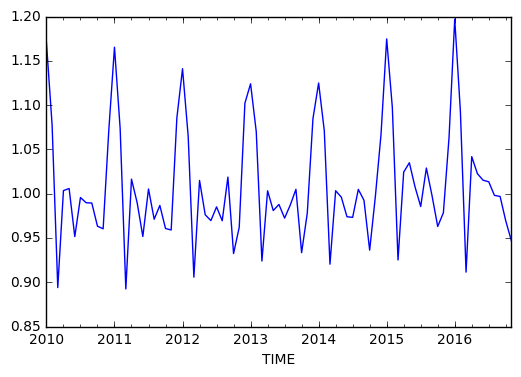

In [459]:
d = "Infrastructure,Other New Work"
kV = consvalueNSA.OBS.unstack(level=0).xs("Month")
kVSA = consvalueSA.OBS.unstack(level=0).xs("Month")
(kVSA[d]/kV[d]).plot()

